In [1]:
from glob import glob
import imageio.v2 as iio
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import pandas as pd
import skan
from skan.pre import threshold
from skan import Skeleton, summarize
from skan import draw
from skan.csr import skeleton_to_csgraph
import os
from skimage import data
from skimage.filters import threshold_otsu
from skimage import morphology
from skimage.morphology import skeletonize, remove_small_objects
from skimage.morphology import disk as morph_disk
from skimage.measure import label, regionprops
from skimage.filters import threshold_local, median  # <-- Use floating-point compatible median
from skimage.util import img_as_ubyte
from skimage.draw import disk as draw_disk  # <--- Use skimage.draw's disk
from skimage.segmentation import clear_border

import networkx as nx
import csv
import math
import itertools
from ipywidgets import interact, widgets, Output
from IPython.display import display
from scipy import ndimage as ndi  # has binary_fill_holes

In [2]:
# Define the directory containing the image files
oringinal_image_directory = '/home/mattliao/agent_based_model/skan/confocal_HR_image_single_cell_15/'
processed_image_mask_directory = '/home/mattliao/agent_based_model/skan/1_image_single_cell_a_final_masks'
processed_image_stack_degree_probability_log = '1_confocal_HR_image_single_cell_a_degree_probabilities_log.txt'
processed_image_first_frame_node_csv = '1_image_single_cell_a_nodes.csv'
processed_image_first_frame_edge_csv = '1_image_single_cell_a_edges.csv'

# Use glob to find all .tif files matching the pattern
original_image_files = sorted(glob(f'{oringinal_image_directory}*.tif'))

# Read each image file
original_images = [iio.imread(file) for file in original_image_files]

# Example: print the shape of the first image
if original_images:
    y, x = original_images[0].shape[:2]
    print(f"x = {x}, y = {y}")
    first_filename = os.path.basename(original_image_files[0])
    print(f"First image file name: {first_filename}")
    print(f"First image shape: {original_images[0].shape}")
else:
    print("No image files found.")

x = 917, y = 917
First image file name: 700000.tif
First image shape: (917, 917)


/home/mattliao/miniconda3/envs/readdy_env/lib/python3.9/site-packages/skimage/draw/draw.py:48: RuntimeWarning: invalid value encountered in divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 + (
/home/mattliao/miniconda3/envs/readdy_env/lib/python3.9/site-packages/skimage/draw/draw.py:49: RuntimeWarning: invalid value encountered in divide
  (r * sin_alpha - c * cos_alpha) / c_rad


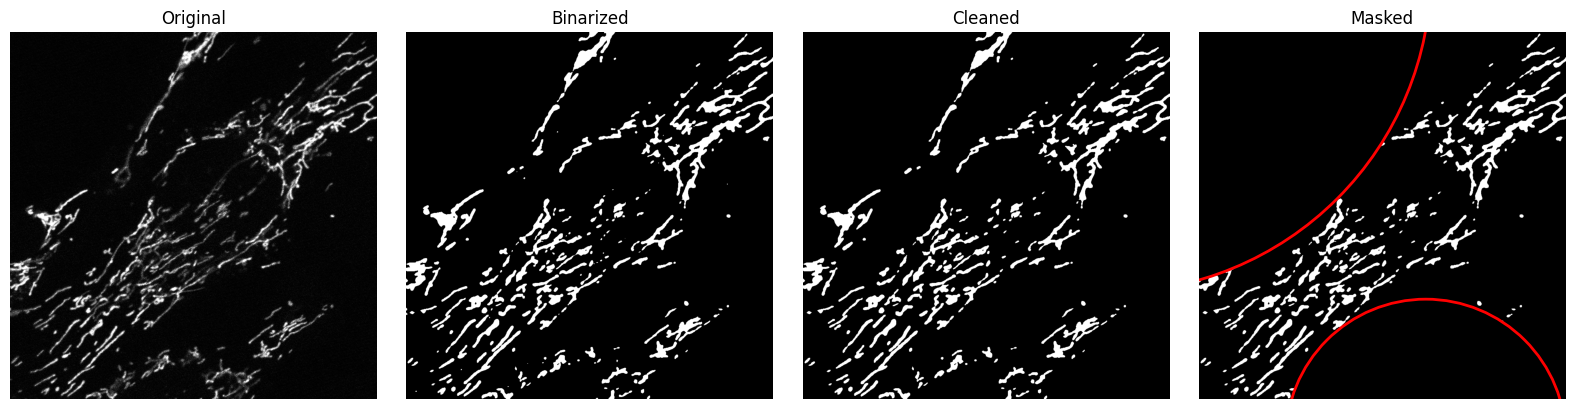

In [3]:
def remove_center_circle(bin_image, radius=20, center=None):
    """
    Removes (sets to False) all pixels within a circular region from the binary image.

    Parameters:
        bin_image (ndarray): 2D binary image.
        radius (int): Radius of the circle to remove.
        center (tuple or None): (row, col) coordinates of the circle center.
                                If None, defaults to image center.

    Returns:
        masked_image (ndarray): Binary image with the central circle removed.
    """
    if center is None:
        center = (bin_image.shape[0] // 2, bin_image.shape[1] // 2)

    rr, cc = draw_disk(center, radius, shape=bin_image.shape)
    masked_image = bin_image.copy()
    masked_image[rr, cc] = False
    return masked_image

# Check for input image list
if len(original_image_files) == 0:
    raise ValueError("No files found. Check your directory and file pattern.")

# Load the first frame (grayscale)
first_frame_img = iio.imread(original_image_files[0])

# Otsu Thresholding
thresh = threshold_otsu(first_frame_img)
adjusted_thresh = thresh * 1  # Modify this ratio as needed
bin_image = first_frame_img > adjusted_thresh

# Denoise using Total Variation filter
bin_image = threshold(bin_image, sigma=2, radius=0)

# Remove small noise blobs
mini_size = 20
cleaned = remove_small_objects(bin_image, min_size=mini_size)

# Define circular regions to be removed
circle_params = [
    ((-150, -220), 800),          # center_1
    ((y, 0), 0),                  # center_2
    ((0, x), 0),                  # center_3
    ((y + 100, x - 350), 350),    # center_4
    ((590, 696), 0)               # center_5
]

# Apply masking
final_mask = cleaned.copy()
for center, radius in circle_params:
    final_mask = remove_center_circle(final_mask, radius=radius, center=center)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(first_frame_img, cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(bin_image, cmap='gray')
axs[1].set_title("Binarized")
axs[1].axis('off')

axs[2].imshow(cleaned, cmap='gray')
axs[2].set_title("Cleaned")
axs[2].axis('off')

axs[3].imshow(final_mask, cmap='gray')
axs[3].set_title("Masked")
axs[3].axis('off')

# Draw all the circles on the final mask
for center, radius in circle_params:
    circle = Circle((center[1], center[0]), radius, edgecolor='red', facecolor='none', linewidth=2)
    axs[3].add_patch(circle)

plt.tight_layout()
plt.show()


In [4]:
# Create output folder for processed masks
final_masks = []
mask_folder = processed_image_mask_directory
os.makedirs(mask_folder, exist_ok=True)

# Process each image
for file in original_image_files:
    # Load image
    first_frame_img = iio.imread(file)

    # Binarization with adjustable Otsu threshold
    thresh = threshold_otsu(first_frame_img)
    bin_image = first_frame_img > adjusted_thresh

    # Denoising
    bin_image = threshold(bin_image, sigma=2, radius=0)

    # Remove small objects
    cleaned = remove_small_objects(bin_image, min_size=mini_size)

    # Apply all circular masks
    final_mask = cleaned.copy()
    for center, radius in circle_params:
        final_mask = remove_center_circle(final_mask, radius=radius, center=center)


    # Store and save mask
    final_masks.append(final_mask)
    filename = os.path.splitext(os.path.basename(file))[0]
    iio.imwrite(os.path.join(mask_folder, f"{filename}_finalmask.png"), (final_mask * 255).astype(np.uint8))

out = Output(layout={'border': '1px solid black', 'height': '800px', 'overflow_y': 'scroll'})

with out:
    interval = 10
    selected_indices = list(range(0, len(original_image_files), interval))
    fig, axs = plt.subplots(len(selected_indices), 4, figsize=(14, 3 * len(selected_indices)))

    for i, idx in enumerate(selected_indices):
        file = original_image_files[idx]
        first_frame_img = iio.imread(file)
        final_mask = final_masks[idx]

        # Recompute binary image (not cleaned for display)
        thresh = threshold_otsu(first_frame_img)
        bin_image = first_frame_img > adjusted_thresh
        bin_image = threshold(bin_image, sigma=2, radius=0)

        # Plot original
        axs[i, 0].imshow(first_frame_img, cmap='gray')
        axs[i, 0].set_title(f"Original (Frame {idx})")
        axs[i, 0].axis('off')

        # Plot binarized
        axs[i, 1].imshow(bin_image, cmap='gray')
        axs[i, 1].set_title("Binarized")
        axs[i, 1].axis('off')

        # Placeholder for cleaned (same as binarized in display)
        axs[i, 2].imshow(bin_image, cmap='gray')
        axs[i, 2].set_title("Cleaned")
        axs[i, 2].axis('off')

        # Plot final masked image
        axs[i, 3].imshow(final_mask, cmap='gray')
        axs[i, 3].set_title("Circle Removed")
        axs[i, 3].axis('off')

        for center, radius in circle_params:
            circle = Circle((center[1], center[0]), radius, edgecolor='red', facecolor='none', linewidth=2)
            axs[i, 3].add_patch(circle)

    plt.tight_layout()
    plt.show()

# Display scrollable viewer
display(out)



Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [5]:
# Step 1: Skeletonize all frames
skeletons = []
for mask in final_masks:
    skeleton = skeletonize(mask)
    skeletons.append(skeleton)

# Step 2: Display every 10th frame
selected_indices = list(range(0, len(skeletons), 10))
out = Output(layout={'border': '1px solid black', 'height': '800px', 'overflow_y': 'scroll'})

with out:
    fig, axs = plt.subplots(len(selected_indices), 2, figsize=(10, 3 * len(selected_indices)))

    for i, idx in enumerate(selected_indices):
        mask = final_masks[idx]
        skeleton = skeletons[idx]

        axs[i, 0].imshow(mask, cmap='gray')
        axs[i, 0].set_title(f"Circle Removed (Frame {idx})")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(skeleton, cmap='gray')
        axs[i, 1].set_title(f"Skeletonized (Frame {idx})")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Display the scrollable widget
display(out)

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [6]:
# List to store summary DataFrames for each skeleton
summaries = []

for idx, skel in enumerate(skeletons):
    # Create a Skeleton object
    skeleton_obj = Skeleton(skel)
    
    # Summarize the skeleton to extract branch data
    summary = summarize(skeleton_obj, find_main_branch=True)
    
    # Add an identifier for the skeleton
    summary['skeleton_id'] = idx
    
    # Append the summary to the list
    summaries.append(summary)

# Combine all summaries into a single DataFrame
combined_summary = pd.concat(summaries, ignore_index=True)

/tmp/ipykernel_1676554/1241810760.py:9: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  summary = summarize(skeleton_obj, find_main_branch=True)
/tmp/ipykernel_1676554/1241810760.py:9: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  summary = summarize(skeleton_obj, find_main_branch=True)
/tmp/ipykernel_1676554/1241810760.py:9: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  summary = summarize(skeleton_obj, find_main_branch=True)
/tmp/ipykernel_1676554/1241810760.

In [7]:
# Assume 'summaries' is a list of skeleton summary DataFrames
graphs = []  # List to store the graphs
node_positions_list = []  # List to store node positions for each graph

for summary in summaries:
    G = nx.Graph()

    # Extract unique node IDs from 'node-id-src' and 'node-id-dst' columns
    node_ids = np.unique(summary[['node-id-src', 'node-id-dst']].values.ravel())

    # Add nodes with their coordinates
    for node_id in node_ids:
        # Find the first occurrence of the node to get its coordinates
        rows = summary[(summary['node-id-src'] == node_id) | (summary['node-id-dst'] == node_id)]
        if not rows.empty:
            row = rows.iloc[0]
            if row['node-id-src'] == node_id:
                coord = (row['image-coord-src-1'], row['image-coord-src-0'])
            else:
                coord = (row['image-coord-dst-1'], row['image-coord-dst-0'])
            G.add_node(node_id, coord=coord)

    # Add edges with their distances
    for _, row in summary.iterrows():
        src = row['node-id-src']
        dst = row['node-id-dst']
        distance = row['branch-distance']
        G.add_edge(src, dst, weight=distance)

    # Store the graph
    graphs.append(G)

    # Extract node positions for visualization
    node_positions = {node: data['coord'] for node, data in G.nodes(data=True)}
    node_positions_list.append(node_positions)

In [8]:
# Fixed bond length for segmentation
bond_length = 10

# List to store the modified graphs
refined_graphs = []

for graph in graphs:
    # Create a new graph to store the modified version
    modified_graph = nx.Graph()
    
    # Copy nodes along with their attributes
    modified_graph.add_nodes_from(graph.nodes(data=True))
    
    # Convert NodeView to a list to avoid issues with functions like max()
    node_list = list(graph.nodes)
    max_node_id = max(node_list) if node_list else 0
    new_node_id_gen = itertools.count(start=max_node_id + 1)

    for u, v, data in graph.edges(data=True):
        x0, y0 = graph.nodes[u]['coord']
        x1, y1 = graph.nodes[v]['coord']

        dx, dy = x1 - x0, y1 - y0
        edge_length = math.hypot(dx, dy)

        # Determine the number of segments to insert
        num_segments = int(edge_length // bond_length)
        if num_segments == 0:
            # If the edge is shorter than the bond length, add it directly
            modified_graph.add_edge(u, v, weight=edge_length)
            continue

        # Calculate unit vector components
        ux, uy = dx / edge_length, dy / edge_length

        prev_node = u
        for i in range(1, num_segments):
            # Calculate coordinates for the new intermediate node
            new_x = x0 + ux * i * bond_length
            new_y = y0 + uy * i * bond_length
            new_id = next(new_node_id_gen)

            # Add the new node with its coordinates
            modified_graph.add_node(new_id, coord=(new_x, new_y))

            # Add an edge from the previous node to the new node
            modified_graph.add_edge(prev_node, new_id, weight=bond_length)
            prev_node = new_id

        # Add the final edge segment to the destination node
        modified_graph.add_edge(prev_node, v, weight=bond_length)

    # Append the modified graph to the list
    refined_graphs.append(modified_graph)

In [9]:
# Constant image height
image_height = skeletons[0].shape[0]

# Select every 10th index
selected_indices = list(range(0, len(skeletons), 10))

# Scrollable output widget
out = Output(layout={'border': '1px solid black', 'height': '800px', 'overflow_y': 'scroll'})

with out:
    fig, axs = plt.subplots(len(selected_indices), 2, figsize=(12, 4 * len(selected_indices)))

    # Ensure axs is 2D even if there's only one item
    if len(selected_indices) == 1:
        axs = [axs]

    for i, idx in enumerate(selected_indices):
        skeleton = skeletons[idx]
        graph = refined_graphs[idx]

        # Build node positions
        node_positions = {
            node: data["coord"]
            for node, data in graph.nodes(data=True)
        }

        # Flip y-coordinates for proper orientation
        node_positions_flipped = {
            node: (x, image_height - y)
            for node, (x, y) in node_positions.items()
        }

        # Plot original skeleton
        axs[i][0].imshow(skeleton, cmap='gray')
        axs[i][0].set_title(f'Skeleton (Frame {idx})')
        axs[i][0].axis('off')

        # Plot modified graph
        nx.draw(
            graph,
            pos=node_positions_flipped,
            with_labels=False,
            node_size=15,
            edge_color='gray',
            width=0.8,
            ax=axs[i][1]
        )
        axs[i][1].set_title(f'Modified Graph (Frame {idx})')
        axs[i][1].axis('equal')
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()

# Show scrollable output
display(out)


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [10]:
# Print node positions
print("Node Positions (image coordinates):")
for node, data in refined_graphs[0].nodes(data=True):
    print(f"Node {node}: coord = {data['coord']}")

# Print edge connectivity and branch length
print("\nEdges (connectivity):")
for u, v, data in refined_graphs[0].edges(data=True):
    print(f"Edge {u} <-> {v}, length = {data['weight']:.2f} px")


Node Positions (image coordinates):
Node 1: coord = (851, 6)
Node 34: coord = (820, 37)
Node 35: coord = (887, 38)
Node 103: coord = (899, 62)
Node 107: coord = (916, 63)
Node 134: coord = (808, 70)
Node 166: coord = (733, 79)
Node 181: coord = (892, 81)
Node 193: coord = (726, 84)
Node 218: coord = (839, 92)
Node 232: coord = (837, 97)
Node 239: coord = (901, 100)
Node 242: coord = (832, 101)
Node 258: coord = (827, 105)
Node 282: coord = (801, 114)
Node 299: coord = (727, 126)
Node 302: coord = (787, 127)
Node 328: coord = (856, 135)
Node 338: coord = (875, 138)
Node 345: coord = (771, 140)
Node 368: coord = (812, 146)
Node 409: coord = (915, 155)
Node 417: coord = (690, 157)
Node 434: coord = (800, 159)
Node 484: coord = (827, 163)
Node 498: coord = (827, 166)
Node 522: coord = (836, 170)
Node 531: coord = (679, 173)
Node 547: coord = (609, 176)
Node 563: coord = (895, 176)
Node 564: coord = (607, 177)
Node 567: coord = (746, 177)
Node 607: coord = (671, 182)
Node 613: coord = (749,

In [11]:
# Assuming 'graph' is your NetworkX graph
with open(processed_image_first_frame_node_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['node_id', 'x_coord', 'y_coord'])
    for node, data in refined_graphs[0].nodes(data=True):
        x, y = data['coord']
        writer.writerow([node, x, y])

In [12]:
with open(processed_image_first_frame_edge_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['source', 'target'])
    for u, v, data in refined_graphs[0].edges(data=True):
        writer.writerow([u, v])

In [13]:
# Iterate through each modified graph
for i, graph in enumerate(refined_graphs):
    # Calculate the degree of each node in the graph
    degrees = [deg for _, deg in graph.degree()]
    
    # Count the frequency of each degree
    degree_counts = Counter(degrees)
    
    # Extract counts for specific degrees
    one_deg = degree_counts.get(1, 0)
    two_deg = degree_counts.get(2, 0)
    three_deg = degree_counts.get(3, 0)
    
    # Display the results
    print(f"Graph {i + 1}:")
    print(f"  1-degree nodes (endpoints): {one_deg}")
    print(f"  2-degree nodes (linear path points): {two_deg}")
    
    print(f"  3-degree nodes (branching points): {three_deg}\n")

NameError: name 'Counter' is not defined

In [ ]:

# Initialize lists to store probabilities
degree_1_probs = []
degree_2_probs = []
degree_3_probs = []

# Open a log file to write the results
with open(processed_image_stack_degree_probability_log, "w") as log_file:
    # Write header
    log_file.write("TimeStep,Degree1_Prob,Degree2_Prob,Degree3_Prob\n")

    # Iterate through each graph
    for t, graph in enumerate(refined_graphs):
        degrees = [deg for _, deg in graph.degree()]
        total_nodes = len(degrees)
        degree_counts = Counter(degrees)

        # Normalize counts to probabilities
        degree_1 = degree_counts.get(1, 0) / total_nodes
        degree_2 = degree_counts.get(2, 0) / total_nodes
        degree_3 = degree_counts.get(3, 0) / total_nodes

        degree_1_probs.append(degree_1)
        degree_2_probs.append(degree_2)
        degree_3_probs.append(degree_3)

        # Log the results
        log_file.write(f"{t},{degree_1:.6f},{degree_2:.6f},{degree_3:.6f}\n")

        # Optionally print
        print(f"Time {t}:")
        print(f"  1-degree nodes (endpoints): {degree_1}")
        print(f"  2-degree nodes (linear path points): {degree_2}")
        print(f"  3-degree nodes (branching points): {degree_3}\n")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(degree_1_probs, label='Degree 1')
plt.plot(degree_2_probs, label='Degree 2')
plt.plot(degree_3_probs, label='Degree 3')

plt.title("Degree Probabilities Over Time")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.legend(title='Degree')
plt.grid(True)
plt.tight_layout()
plt.show()
